In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from glob import glob

import stan_utils as stan
from mpl_utils import (mpl_style, common_limits)

plt.style.use(mpl_style)

np.random.seed(42)

%matplotlib inline

In [2]:
survey_data_paths = glob("data/*.csv")
survey_data = [Table.read(dp) for dp in survey_data_paths]

In [3]:
for dp, d in zip(survey_data_paths, survey_data):
    print(dp, d.dtype.names)

data/Adibekyan12-all-renorm.csv ('HIP', 'Star', 'Teff', 'logg', 'FeH', 'NaH', 'MgH', 'AlH', 'SiH', 'CaH', 'ScIH', 'ScIIH', 'TiIH', 'TiIIH', 'VH', 'CrIH', 'CrIIH', 'MnH', 'CoH', 'NiH')
data/Bensby14-all-renorm.csv ('HIP', 'Teff', 'logg', 'FeH', 'OH', 'NaH', 'MgH', 'AlH', 'SiH', 'CaH', 'TiH', 'CrH', 'NiH', 'ZnH', 'YH', 'BaH')
data/Valenti05-all-renorm.csv ('HIP', 'HD', 'Teff', 'logg', 'NaH', 'SiH', 'TiH', 'FeH', 'NiH')


In [49]:
label_identifier = "HIP"
label_names = ("Teff", "logg", "FeH", "SiH")
latex_label_names = [
    r"$T_{\rm eff}$",
    r"$\log{g}$",
    r"\textrm{[Fe/H]}",
    r"\textrm{[Si/H]}",
]

In [5]:
# generate the data arrays
unique_hip_names = np.sort(np.unique(np.hstack([d["HIP"] for d in survey_data])))
N = unique_hip_names.size
M = len(survey_data)
D = len(label_names)

y = np.nan * np.ones((N, M, D), dtype=float)

In [6]:
for m, data in enumerate(survey_data):
    for i, star in enumerate(data):
        n = np.where(star[label_identifier] == unique_hip_names)[0][0]
        y[n, m, :] = np.array([(star[ln] if ln in star.dtype.names else np.nan) \
                               for ln in label_names])
        

In [7]:
# set bad abundances as nans
for d, label_name in enumerate(label_names):
    if label_name not in ("Teff", "logg"):
        y[:, :, d][(y[:, :, d] >= 90)] = np.nan


In [9]:
# Only use stars that are common to all surveys
y
y.shape

(2237, 3, 4)

In [10]:
y.reshape((N, -1))

array([[ 5.185e+03,  4.440e+00, -3.000e-02, ...,        nan,        nan,
               nan],
       [ 5.894e+03,  4.360e+00, -5.300e-01, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [ 6.158e+03,  4.670e+00, -1.000e-02, ...,        nan,        nan,
               nan],
       [ 5.436e+03,  4.390e+00, -2.000e-01, ...,        nan,        nan,
               nan],
       [ 5.504e+03,  4.470e+00, -4.000e-01, ...,        nan,        nan,
               nan]])

In [15]:
np.sum(np.all(np.isfinite(y.reshape((N, -1))), axis=1))

61

In [21]:
keep = np.all(np.isfinite(y.reshape((N, -1))), axis=1)

y = y[keep]
N = sum(keep)


In [22]:
# checks
for d, label_name in enumerate(label_names):
    _ = y[:, :, d]
    print("{0}: ({1:.1f} to {2:.1f}), mean/median/std: {3:.1f}/{4:.1f}/{5:.1f} ({6:.0f} finite)".format(
          label_name, np.nanmin(_), np.nanmax(_), 
          np.nanmean(_), np.nanmedian(_), np.nanstd(_),
          np.sum(np.isfinite(_))))

Teff: (4796.0 to 6459.0), mean/median/std: 5716.8/5720.0/281.8 (183 finite)
logg: (3.8 to 4.8), mean/median/std: 4.4/4.4/0.2 (183 finite)
FeH: (-1.4 to 0.4), mean/median/std: -0.1/0.0/0.4 (183 finite)
SiH: (-1.4 to 0.4), mean/median/std: -0.0/0.0/0.3 (183 finite)


In [23]:
# We don't have missing data here.
y_full_rank = y
extra_variance = np.zeros(y.shape)

In [57]:
model = stan.read_model("model-missing-data.stan")
print(model.model_code)

INFO:root:Using pre-compiled model from model-missing-data.stan.cached



/*
  Latent factor model for chemical abundances from multiple studies, allowing
  for missing data.
*/

data {
  int<lower=1> N; // number of stars
  int<lower=1> D; // dimensionality of the data (number of labels)
  int<lower=1> M; // number of surveys (or studies)
  vector[D] y[N, M]; // the labels as reported by various surveys.
  vector<lower=0>[D] scales; // fixed relative scales for latent factors
  vector[D] y_additive_variance[N, M]; // variance to add for missing data.
}

transformed data {
  vector[D] mu; // the mean of the data in each dimension
  int<lower=1> Q; // the number of non-zero lower-triangular entries that we
                  // need for the decomposoition of our theta matrix
  Q = M * choose(D, 2);

  // TODO: Stop assuming that the user is not an idiot
  mu = rep_vector(0.0, D);
}

parameters {
  vector[D] X[N]; // latent factors for each star
  vector<lower=0>[M] phi[D]; // variance on survey labels

  vector[Q] L_lower_triangular; // lower triangular entri

In [25]:
# Optimize the model.
mu = np.mean(y_full_rank.reshape((-1, D)), axis=0)
scales = np.std(y_full_rank.reshape((-1, D)), axis=0)

# TODO: HANDLE THE SCALES PROPERLY
data = dict(N=N, M=M, D=D, scales=np.ones(D), 
            y=(y_full_rank - mu)/scales, 
            y_additive_variance=extra_variance)

op_kwds = dict(
    data=data, 
    iter=100000, 
    tol_obj=7./3 - 4./3 - 1, # machine precision
    tol_grad=7./3 - 4./3 - 1, # machine precision
    tol_rel_grad=1e3,
    tol_rel_obj=1e4
)

p_opt = model.optimizing(**op_kwds)

/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:362: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(np.asarray(v).dtype, int):
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:364: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [26]:
print(p_opt)

OrderedDict([('X', array([[ 7.02698434e-01,  5.38688521e-01, -1.19880337e-01,
        -1.74951466e-01],
       [ 5.98434537e-01, -2.37848855e-01, -3.50178120e-01,
        -1.43448047e-01],
       [-2.26823008e-01,  2.62487071e-01, -3.17064205e-01,
        -2.34626220e-01],
       [-6.85689021e-02,  2.53962098e-02, -5.31364063e-01,
        -3.42304111e-02],
       [ 1.23497890e+00,  9.76862972e-01,  3.24478491e-01,
        -1.93251721e-01],
       [ 9.49792129e-02,  3.34542885e-02, -3.03498805e-01,
        -1.20148852e-02],
       [ 6.46329979e-03,  7.09707318e-02, -3.29573616e-01,
        -1.35067905e-02],
       [-3.81257349e-03, -6.65903938e-01,  5.67925637e-01,
         8.14697644e-02],
       [ 8.81149263e-03, -7.85633319e-01,  4.37009499e-01,
         1.09141626e-01],
       [ 1.13898299e+00,  6.43576980e-01,  6.59189986e-01,
        -4.11441503e-03],
       [-6.05641457e-01,  8.60409830e-02, -9.89562238e-01,
        -8.15097743e-02],
       [ 1.31210082e+00,  4.55829394e-01,  7.6

In [32]:
print(p_opt["X"].shape)
print(p_opt["theta"].shape)
print(N, M, D)

(61, 4)
(3, 4, 4)
61 3 4


In [35]:
np.dot(p_opt["X"], p_opt["theta"][0]) * scales + mu

array([[ 5.71680874e+03,  4.50999994e+00, -1.99722621e-01,
        -1.29780434e-01],
       [ 5.71680874e+03,  4.30999977e+00, -2.56288555e-01,
        -1.60267544e-01],
       [ 5.71680874e+03,  4.44000012e+00, -2.81151987e-01,
        -2.04067822e-01],
       [ 5.71680874e+03,  4.38000048e+00, -2.92584596e-01,
        -1.39738134e-01],
       [ 5.71680874e+03,  4.61999956e+00, -5.77803444e-02,
        -4.56389474e-02],
       [ 5.71680874e+03,  4.38000002e+00, -2.06332298e-01,
        -7.88728962e-02],
       [ 5.71680874e+03,  4.39000024e+00, -2.16626958e-01,
        -8.53376510e-02],
       [ 5.71680874e+03,  4.18999983e+00,  1.39993152e-01,
         1.59980623e-01],
       [ 5.71680874e+03,  4.16000019e+00,  1.04569927e-01,
         1.47368189e-01],
       [ 5.71680874e+03,  4.53000031e+00,  1.21693587e-01,
         1.30102106e-01],
       [ 5.71680874e+03,  4.40000022e+00, -4.68261486e-01,
        -2.63704572e-01],
       [ 5.71680874e+03,  4.47999996e+00,  2.06338217e-01,
      

(3, 4, 4)


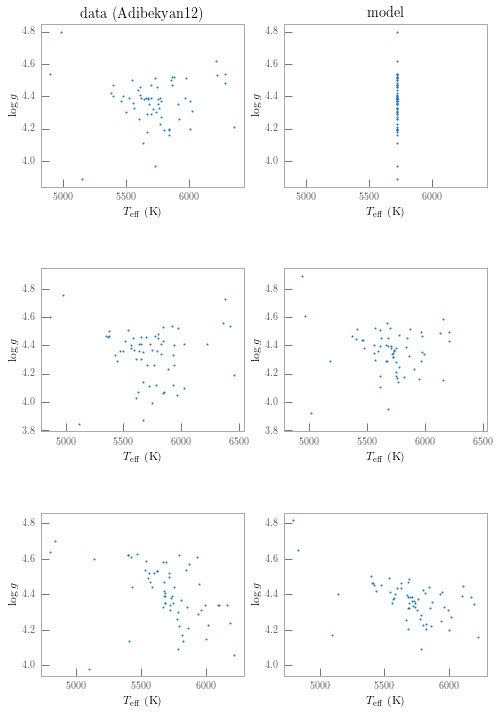

In [37]:
#  Plot model predictions compared to the data.

print(p_opt["theta"].shape)

xi, yi = range(2) # indices to plot.

fig, axes = plt.subplots(M, 2, figsize=(4 * 2, 4 * M))
axes = np.array(axes)

for m in range(M):
    ax_data, ax_model = axes[m]
    
    ax_data.scatter(y[:, m, xi],
                    y[:, m, yi],
                    s=1)
    
    y_tilde = np.dot(p_opt["X"], p_opt["theta"][m]) * scales + mu
    ax_model.scatter(y_tilde[:, xi],
                     y_tilde[:, yi],
                     s=1)
    
    survey_reference = survey_data_paths[m].split("/")[1].split("-")[0]
    
    for ax in (ax_data, ax_model):
        ax.set_xlabel(latex_label_names[xi])
        ax.set_ylabel(latex_label_names[yi])
    
    ax_model.set_title(r"\textrm{model}")
    ax_data.set_title(r"\textrm{{data ({0})}}".format(
                      survey_reference))

    xlimits = np.hstack([ax_model.get_xlim(), ax_data.get_xlim()])
    ylimits = np.hstack([ax_model.get_ylim(), ax_data.get_ylim()])
    xlimits = (np.min(xlimits), np.max(xlimits))
    ylimits = (np.min(ylimits), np.max(ylimits))
    
    for ax in (ax_model, ax_data):
        ax.set_xlim(xlimits)
        ax.set_ylim(ylimits)
    

In [40]:
# WTF with the model data for adebekiyan
np.ptp(np.dot(p_opt["X"], p_opt["theta"][0]) * scales + mu, axis=0)

array([2.72848411e-12, 9.09999762e-01, 1.71739016e+00, 1.70085646e+00])

In [42]:
p_opt["theta"][0]

array([[ 5.19254672e-30,  1.64644162e-15,  1.78500776e-15,
         1.54652989e-15],
       [ 1.64644162e-15,  1.54583117e+00, -5.39392312e-02,
        -7.57477673e-03],
       [ 1.78500776e-15, -5.39392312e-02,  9.89001644e-01,
         8.32795581e-01],
       [ 1.54652989e-15, -7.57477673e-03,  8.32795581e-01,
         2.13194199e+00]])

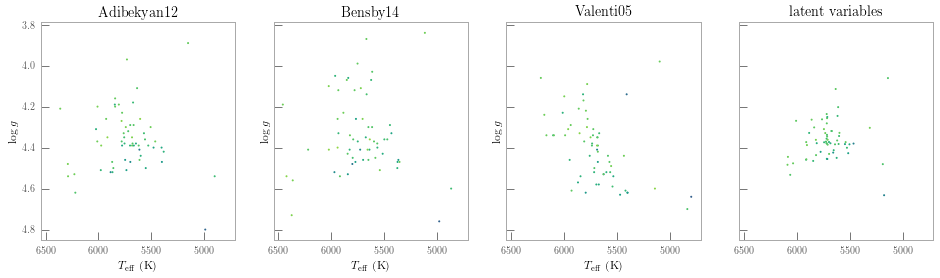

In [43]:
# Plot the H-R diagram of labels from various surveys, and the inferred latent variables
xi, yi, zi = range(3)

z = np.hstack([y[:, :, zi].flatten(), p_opt["X"][:, zi].flatten()])
kwds = dict(vmin=np.nanmin(z), vmax=np.nanmax(z),
            s=1, cmap="viridis")

fig, axes = plt.subplots(1, M + 1, figsize=(4 * (M + 1), 4),
                         sharex=True, sharey=True)

for m, ax in enumerate(axes[:M]):
    #ax.set_title("")
    ax.scatter(y[:, m, xi], y[:, m, yi], c=y[:, m, zi],
               **kwds)
    
    ax.set_xlabel(latex_label_names[xi])
    ax.set_ylabel(latex_label_names[yi])
    
    survey_reference = survey_data_paths[m].split("/")[1].split("-")[0]
    ax.set_title(r"\textrm{{{0}}}".format(survey_reference))

X = p_opt["X"] * scales + mu

ax = axes[-1]
ax.scatter(X[:, xi], X[:, yi], c=X[:, zi], **kwds)
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlim(ax.get_xlim()[::-1])

ax.set_title(r"\textrm{latent variables}")


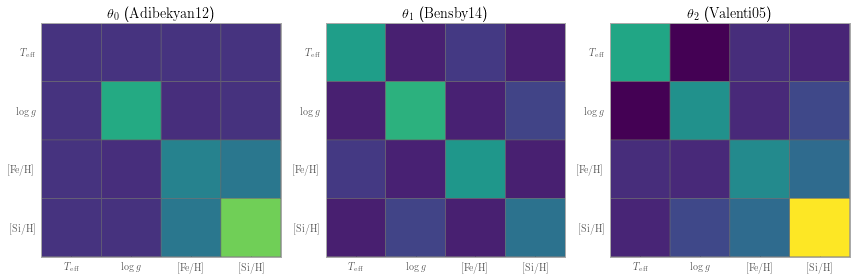

In [51]:
# Plot the theta coefficients for each survey.
fig, axes = plt.subplots(1, M, figsize=(4 * M, 4))

kwds = dict(cmap="viridis", edgecolors="#666666", linewidths=0.5,
            vmin=np.min(p_opt["theta"]), vmax=np.max(p_opt["theta"]))

for m, ax in enumerate(axes):
    theta = p_opt["theta"][m]
    ax.pcolor(theta.T, **kwds)
    
    survey_reference = survey_data_paths[m].split("/")[1].split("-")[0]
    ax.set_title(r"$\theta_{{{0}}}$ (\textrm{{{1}}})".format(m, survey_reference))
    ax.set_xticks(0.5 + np.arange(D))
    ax.set_yticks(0.5 + np.arange(D))
    ax.set_xticklabels(latex_label_names)
    ax.set_yticklabels(latex_label_names)
    
    ax.set_ylim(ax.get_ylim()[::-1])
    
fig.tight_layout()

In [46]:
print(kwds)

{'cmap': 'viridis', 'edgecolors': '#666666', 'linewidths': 0.5, 'vmin': -0.4902675431701427, 'vmax': 2.8631347082365397}


(61, 3, 4)


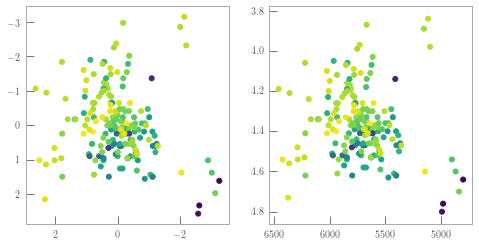

In [54]:
print(data["y"].shape)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

y0 = data["y"].reshape((-1, D))
y1 = y0 * scales + mu

axes[0].scatter(y0[:, 0],
                y0[:, 1],
                c=y0[:, 2])

axes[1].scatter(y1[:, 0],
                y1[:, 1],
                c=y1[:, 2])

for ax in axes:
    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_ylim(ax.get_ylim()[::-1])

In [55]:
data

{'D': 4,
 'M': 3,
 'N': 61,
 'scales': array([1., 1., 1., 1.]),
 'y': array([[[ 9.23449926e-01,  8.40513360e-01, -2.37654956e-01,
          -5.24497094e-01],
         [ 7.63739537e-01, -2.28876755e-01, -2.65877446e-01,
           2.23331088e-01],
         [ 8.20525453e-01,  5.43460550e-01, -3.50544916e-01,
          -5.55656602e-01]],
 
        [[ 1.08316031e+00, -3.47697879e-01, -5.19879855e-01,
          -7.65983278e-01],
         [ 8.73762249e-01, -1.89237249e+00, -4.06989895e-01,
           2.62280473e-01],
         [ 1.05476736e+00, -8.22982374e-01, -4.91657365e-01,
          -7.89352909e-01]],
 
        [[-4.18117336e-01,  4.24639426e-01, -5.19879855e-01,
          -8.82831432e-01],
         [-5.45885646e-01,  1.86997179e-01, -4.63434875e-01,
           2.62280473e-01],
         [-4.14568216e-01,  8.99923922e-01, -5.19879855e-01,
          -7.89352909e-01]],
 
        [[-2.58406948e-01,  6.81760547e-02, -6.89214795e-01,
          -6.37450309e-01],
         [-2.79701666e-01,  2.46

In [58]:
# Let's try re-optimizing from a different point.
init = dict([(k, v) for k, v in p_opt.items()])

In [60]:
#init["L"].shape
init["L"][0] = init["L"][2]
init["L"][1] = init["L"][2]


(3, 4, 4)

In [61]:
op_kwds = dict(
    data=data, 
    init=init,
    iter=100000, 
    tol_obj=7./3 - 4./3 - 1, # machine precision
    tol_grad=7./3 - 4./3 - 1, # machine precision
    tol_rel_grad=1e2,
    tol_rel_obj=1e4
)

In [62]:
p_opt_next = model.optimizing(**op_kwds)

/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:362: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(np.asarray(v).dtype, int):
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:364: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


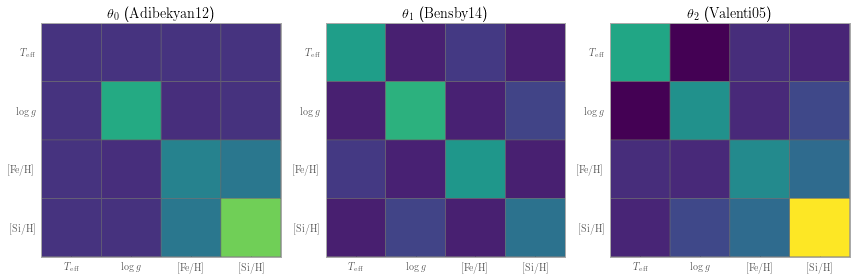

In [64]:
# Plot the theta coefficients for each survey.
fig, axes = plt.subplots(1, M, figsize=(4 * M, 4))

kwds = dict(cmap="viridis", edgecolors="#666666", linewidths=0.5,
            vmin=np.min(p_opt_next["theta"]), vmax=np.max(p_opt_next["theta"]))

for m, ax in enumerate(axes):
    theta = p_opt_next["theta"][m]
    ax.pcolor(theta.T, **kwds)
    
    survey_reference = survey_data_paths[m].split("/")[1].split("-")[0]
    ax.set_title(r"$\theta_{{{0}}}$ (\textrm{{{1}}})".format(m, survey_reference))
    ax.set_xticks(0.5 + np.arange(D))
    ax.set_yticks(0.5 + np.arange(D))
    ax.set_xticklabels(latex_label_names)
    ax.set_yticklabels(latex_label_names)
    
    ax.set_ylim(ax.get_ylim()[::-1])
    
fig.tight_layout()

If we place a stronger prior on the diagonal elements of :math:`\theta` to be close to unity then that should be enough to get rid of this issue,...right?

## CHE CHATZA!?!

In [67]:
model_code = """
/*
  Latent factor model for chemical abundances from multiple studies, allowing
  for missing data.

  This model includes priors on *ALL* the elements of the theta matrices!
*/

data {
  int<lower=1> N; // number of stars
  int<lower=1> D; // dimensionality of the data (number of labels)
  int<lower=1> M; // number of surveys (or studies)
  vector[D] y[N, M]; // the labels as reported by various surveys.
  vector<lower=0>[D] scales; // fixed relative scales for latent factors
  vector[D] y_additive_variance[N, M]; // variance to add for missing data.
}

transformed data {
  vector[D] mu; // the mean of the data in each dimension
  int<lower=1> Q; // the number of non-zero lower-triangular entries that we
                  // need for the decomposoition of our theta matrix
  Q = M * choose(D, 2);

  // TODO: Stop assuming that the user is not an idiot
  mu = rep_vector(0.0, D);
}

parameters {
  vector[D] X[N]; // latent factors for each star
  vector<lower=0>[M] phi[D]; // variance on survey labels

  vector[Q] L_lower_triangular; // lower triangular entries of the decomposition
                                // of the  theta matrix
  vector<lower=0>[M] L_diag[D]; // diagonal entries of the decomposition of the 
                                // theta matrix
}

transformed parameters {
  cholesky_factor_cov[D, D] L[M];
  matrix[D, D] theta[M];
  {
    int q = 0;

    for (m in 1:M)
      for (i in 1:D)
        for (j in (i + 1):D) 
          L[m, i, j] = 0.0;

    for (m in 1:M) {
      for (i in 1:D) {
        L[m, i, i] = L_diag[i, m];
        for (j in (i + 1):D) {
          q = q + 1;
          L[m, j, i] = L_lower_triangular[q];
        }
      }
    }

    for (m in 1:M)
      theta[m] = multiply_lower_tri_self_transpose(L[m]);
  }
}

model {

  // Place priors on various properties.
  for (d in 1:D) {
    X[:, d] ~ normal(rep_vector(0, N), rep_vector(scales[d], N));
    phi[d] ~ normal(rep_vector(0, M), rep_vector(1, M));

    // TODO: revisit this prior
    L_diag[d] ~ normal(rep_vector(1, M), rep_vector(0.1, M));
  }

  L_lower_triangular ~ normal(0, 1);
  
  for (n in 1:N) 
    for (m in 1:M)
      y[n, m, :] ~ normal(to_row_vector(X[n]) * theta[m], 
                          sqrt(to_vector(phi[:, m]) + y_additive_variance[n, m, :]));
}

"""

new_model_path = "model-missing-data-with-priors.stan"
with open(new_model_path, "w") as fp:
    fp.write(model_code)
    
new_model = stan.read_model(new_model_path)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0130eae5e5c1714e4df37ee480157b1d NOW.


In [68]:
op_kwds = dict(
    data=data, 
    iter=100000, 
    tol_obj=7./3 - 4./3 - 1, # machine precision
    tol_grad=7./3 - 4./3 - 1, # machine precision
    tol_rel_grad=1e2,
    tol_rel_obj=1e4
)
p_opt2 = new_model.optimizing(**op_kwds)


/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:362: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(np.asarray(v).dtype, int):
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:364: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


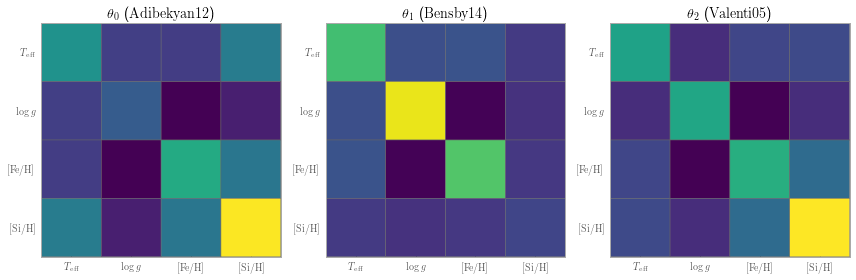

In [69]:
# Plot the theta coefficients for each survey.
fig, axes = plt.subplots(1, M, figsize=(4 * M, 4))

show_p_opt = p_opt2

kwds = dict(cmap="viridis", edgecolors="#666666", linewidths=0.5,
            vmin=np.min(show_p_opt["theta"]), vmax=np.max(show_p_opt["theta"]))

for m, ax in enumerate(axes):
    ax.pcolor(show_p_opt["theta"][m].T, **kwds)
    
    survey_reference = survey_data_paths[m].split("/")[1].split("-")[0]
    ax.set_title(r"$\theta_{{{0}}}$ (\textrm{{{1}}})".format(m, survey_reference))
    ax.set_xticks(0.5 + np.arange(D))
    ax.set_yticks(0.5 + np.arange(D))
    ax.set_xticklabels(latex_label_names)
    ax.set_yticklabels(latex_label_names)
    
    ax.set_ylim(ax.get_ylim()[::-1])
    
fig.tight_layout()

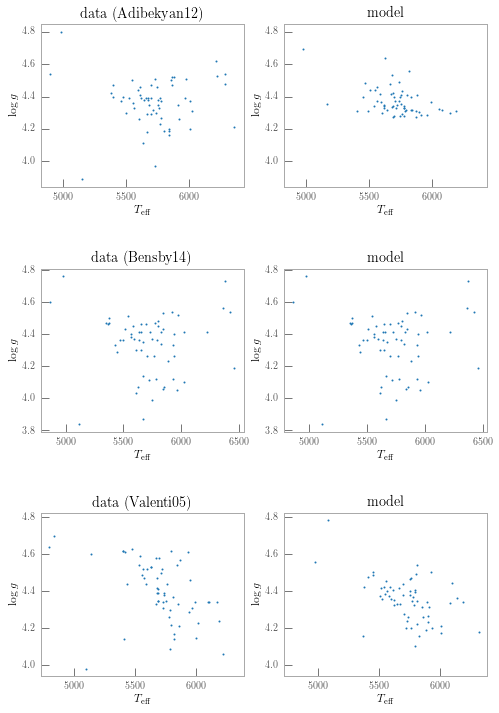

In [70]:
#  Plot model predictions compared to the data.

xi, yi = range(2) # indices to plot.

fig, axes = plt.subplots(M, 2, figsize=(4 * 2, 4 * M))
axes = np.array(axes)

for m in range(M):
    ax_data, ax_model = axes[m]
    
    ax_data.scatter(y[:, m, xi],
                    y[:, m, yi],
                    s=1)
    
    y_tilde = np.dot(show_p_opt["X"], show_p_opt["theta"][m]) * scales + mu
    ax_model.scatter(y_tilde[:, xi],
                     y_tilde[:, yi],
                     s=1)
    
    survey_reference = survey_data_paths[m].split("/")[1].split("-")[0]
    
    for ax in (ax_data, ax_model):
        ax.set_xlabel(latex_label_names[xi])
        ax.set_ylabel(latex_label_names[yi])
    
    ax_model.set_title(r"\textrm{model}")
    ax_data.set_title(r"\textrm{{data ({0})}}".format(
                      survey_reference))

    xlimits = np.hstack([ax_model.get_xlim(), ax_data.get_xlim()])
    ylimits = np.hstack([ax_model.get_ylim(), ax_data.get_ylim()])
    xlimits = (np.min(xlimits), np.max(xlimits))
    ylimits = (np.min(ylimits), np.max(ylimits))
    
    for ax in (ax_model, ax_data):
        ax.set_xlim(xlimits)
        ax.set_ylim(ylimits)
    

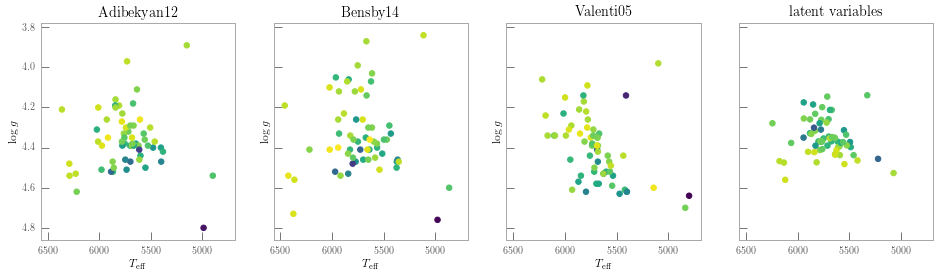

In [71]:
# Plot the H-R diagram of labels from various surveys, and the inferred latent variables
xi, yi, zi = range(3)

z = np.hstack([
    y[:, :, zi].flatten(), 
    (show_p_opt["X"][:, zi] * scales[zi] + mu[zi]).flatten()
])

kwds = dict(vmin=np.nanmin(z), vmax=np.nanmax(z),
            s=30, cmap="viridis")

fig, axes = plt.subplots(1, M + 1, figsize=(4 * (M + 1), 4),
                         sharex=True, sharey=True)

for m, ax in enumerate(axes[:M]):
    ax.scatter(y[:, m, xi], y[:, m, yi], c=y[:, m, zi],
               **kwds)
    
    ax.set_xlabel(latex_label_names[xi])
    ax.set_ylabel(latex_label_names[yi])
    
    survey_reference = survey_data_paths[m].split("/")[1].split("-")[0]
    ax.set_title(r"\textrm{{{0}}}".format(survey_reference))

X = show_p_opt["X"] * scales + mu

ax = axes[-1]
ax.scatter(X[:, xi], X[:, yi], c=X[:, zi], **kwds)
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlim(ax.get_xlim()[::-1])

ax.set_title(r"\textrm{latent variables}")


In [ ]:
# separate figures so people  don't  bitch about them being too LARGE


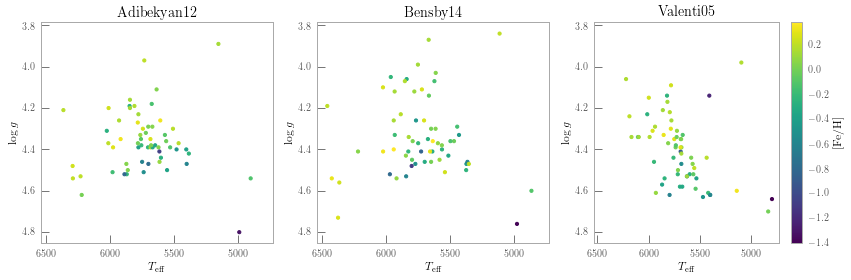

In [72]:
# Plot the H-R diagram of labels from various surveys, and the inferred latent variables
xi, yi, zi = range(3)

z = np.hstack([
    y[:, :, zi].flatten(), 
    (show_p_opt["X"][:, zi] * scales[zi] + mu[zi]).flatten()
])

kwds = dict(vmin=np.nanmin(z), vmax=np.nanmax(z),
            s=10, cmap="viridis")

K = M
fig, axes = plt.subplots(1, K, figsize=(4 * K, 4))

for m, ax in enumerate(axes[:M]):
    scat = ax.scatter(
        y[:, m, xi], 
        y[:, m, yi], 
        c=y[:, m, zi], **kwds)
    
    survey_reference = survey_data_paths[m].split("/")[1].split("-")[0]
    ax.set_title(r"\textrm{{{0}}}".format(survey_reference))

xlimits = np.hstack([ax.get_xlim() for ax in axes])
ylimits = np.hstack([ax.get_ylim() for ax in axes])

xlimits = (np.max(xlimits), np.min(xlimits))
ylimits = (np.max(ylimits), np.min(ylimits))

for ax in axes:
    ax.set_xlabel(latex_label_names[xi])
    ax.set_ylabel(latex_label_names[yi])
    ax.set_xlim(xlimits)
    ax.set_ylim(ylimits)
    
cbar = plt.colorbar(scat)
cbar.set_label(latex_label_names[zi])

fig.tight_layout()


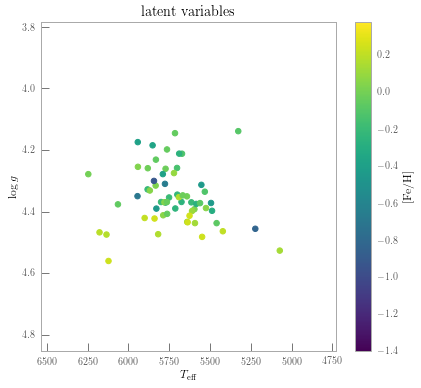

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5.5))

X = show_p_opt["X"] * scales + mu
kwds.update(s=30)
scat = ax.scatter(X[:, xi], X[:, yi], c=X[:, zi], **kwds)
cbar = plt.colorbar(scat)
cbar.set_label(latex_label_names[zi])

ax.set_xlabel(latex_label_names[xi])
ax.set_ylabel(latex_label_names[yi])
ax.set_ylim(ylimits)
ax.set_xlim(xlimits)

ax.set_title(r"\textrm{latent variables}")

fig.tight_layout()